<a href="https://colab.research.google.com/github/alessiomodonesi/Python-Exercises/blob/main/ai/lab11/Intelligenza_Artificiale_Lab11_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Laboratory 11 Lecture

In this lecture, we will use [Tensorflow](https://www.tensorflow.org/) and in particular the [Keras Sequential API](https://www.tensorflow.org/guide/keras/sequential_model), that allows to easily create a model from few lines of code.

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
# The following lines allows to exploit the GPU and make the training faster (Check in the Runtime - Change Runtime time if the GPU is set)
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Download the dataset
Let's downlowad the Cats vs Dogs binary classification dataset. At the end, we will have a PetImages folder which contain two subfolders, Cat and Dog. Each subfolder contains image files for each category.

In [ ]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
!unzip -q kagglecatsanddogs_5340.zip
!ls

!ls PetImages

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0  91.1M      0  0:00:08  0:00:08 --:--:-- 69.6M
 CDLA-Permissive-2.0.pdf   kagglecatsanddogs_5340.zip  'readme[1].txt'
 img.jpg		   PetImages		        sample_data
Cat  Dog


## Filter out corrupted images
When working with lots of real-world image data, corrupted images are a common occurence. Let's filter out badly-encoded images that do not feature the string "JFIF" in their header in this case.

In [ ]:
import os

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 1590 images


## Generate a Dataset

We use the [image_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory) utility in Keras to generate the training and validation sets from image files in a directory.

In [ ]:
image_size = (180, 180)
batch_size = 128


train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

print("Training set: %d images" % len(train_ds))
print("Validation set: %d images" % len(val_ds))


Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Using 4682 files for validation.
Training set: 147 images
Validation set: 37 images


## Check the data

In [ ]:
import numpy as np
train_ds_iterator = train_ds.as_numpy_iterator() # it is an iterator on the training dataset
batch = train_ds_iterator.next()
print(batch[0].shape) #the number of images from batch, it should correspond to the ones specified in the keras.utilis.image_dataset_from_directory
print(batch[1]) # this corresponds to the label

(128, 180, 180, 3)
[1 1 0 1 1 1 0 1 0 1 1 1 0 0 0 0 1 0 0 1 0 0 0 0 0 1 1 0 0 1 0 1 0 1 1 0 1
 1 0 0 1 1 0 1 1 0 1 0 1 0 0 1 1 1 1 0 1 0 1 0 0 1 1 1 0 0 1 0 1 1 0 1 1 1
 0 0 0 1 1 0 1 0 0 1 0 0 1 0 1 1 0 1 0 1 0 0 1 0 1 1 0 0 0 0 1 1 0 1 0 1 0
 0 1 0 1 0 0 1 0 0 1 1 0 0 0 1 1 0]


## Visualize the data
To visualize the data on the dataset, we can use [matplotlib](https://matplotlib.org/3.5.3/api/_as_gen/matplotlib.pyplot.html). For instance, we plot the 9 images in the training dataset and the corresponding label. As you can see, label 1 is associated with "dog" and label 0 with "cat".

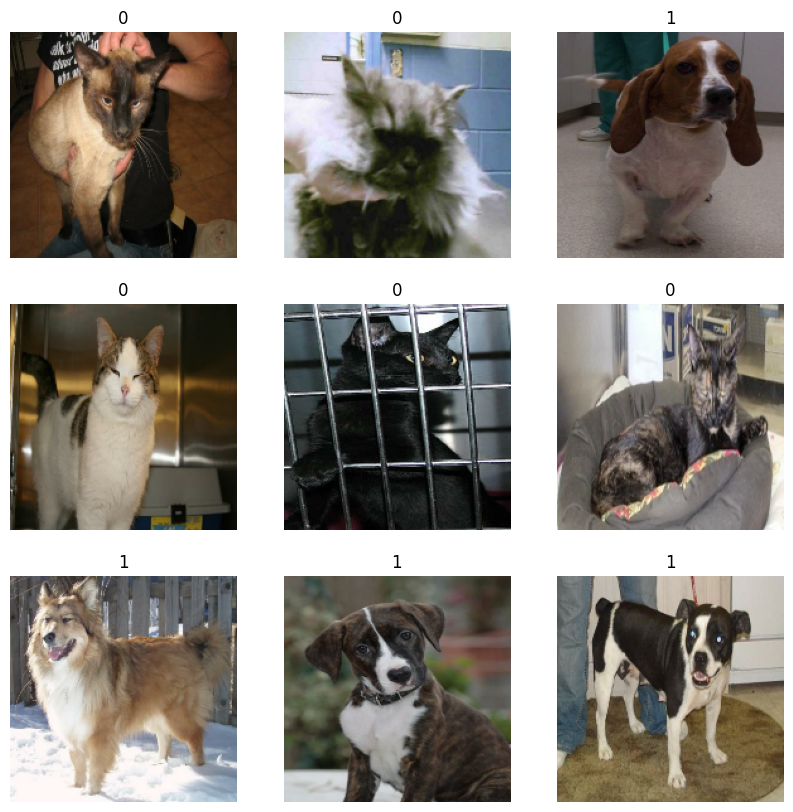

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

## Using image data augmentation
It's a good practice to artificially introduce sample diversity by applying random yet realistic transformations to the training images, such as random horizontal flipping or small random rotations for instance. This helps expose the model to different aspects of the training data while slowing down overfitting.

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

Let's visualize what the augmented samples look like, by applying data_augmentation repeatedly to the first image in the dataset:

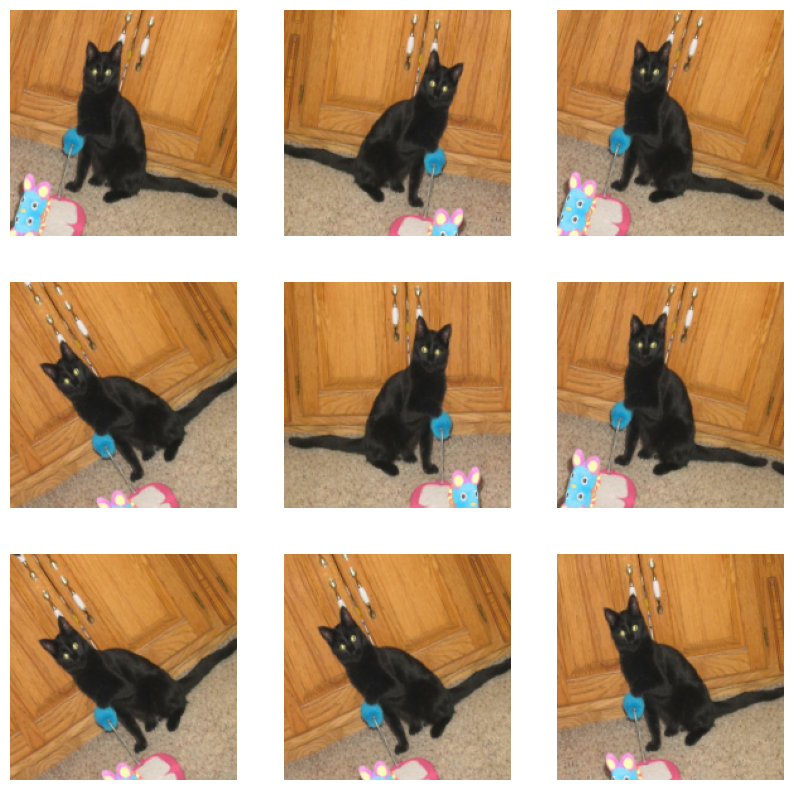

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

## Standardizing the data
The images that we are using are already in a standard size (180x180), as they are being yielded as contiguous float32 batches by our dataset. However, their RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general you should seek to make your input values small. Here, we will standardize values to be in the [0, 1] by using a Rescaling layer at the start of our model.

In [ ]:
train_ds = train_ds.map(lambda x,y: (x/255, y))
val_ds = val_ds.map(lambda x,y: (x/255, y))
print(train_ds.as_numpy_iterator().next()[0].min()) # we check for instance the min
print(train_ds.as_numpy_iterator().next()[0].max()) # we check for instance the max

0.0
1.0


## Configure the dataset for performance
Let's apply data augmentation to our training dataset, and let's make sure to use buffered prefetching so we can yield data from disk without having I/O becoming blocking:

In [ ]:
# Apply `data_augmentation` and standardization to the training images.
train_ds = train_ds.map(    # apply a sort of transformation, it is quick
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
print(train_ds.as_numpy_iterator().next()[0].max())
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

1.0


## Build a model

Create the convolutional base
The lines of code below define the convolutional base using a common pattern: a stack of Conv2D and MaxPooling2D layers.

As input, a CNN takes tensors of shape (image_height, image_width, color_channels), ignoring the batch size. color_channels refers to (R,G,B). In this example, you will configure your CNN to process inputs of shape (180, 180, 1). You can do this by passing the argument input_shape to your first layer.

In [ ]:
from tensorflow.keras import models
model = models.Sequential() # Sequential you have one inpunt and one output as in this case

# There are some hyperparameters in the architecture, according to these, the performance of the architecture can change

# We add then the layer sequentially
model.add(layers.Conv2D(16, (3, 3), 1, activation='relu', input_shape=(180, 180, 3)))

# The first parameter in Conv2D is the number of filters
# The dimention 3x3 in this case
# 1 pixel as stride
# the output pass through an activation function (relu in this case)
# input shape
model.add(layers.MaxPooling2D((2, 2))) ## go the max in the region and condense this information down, the region size is 2x2
model.add(layers.Conv2D(16, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Add Dense layers on top to complete the model, you will feed the last output tensor from the convolutional base into one or more Dense layers to perform classification. Dense layers take vectors as input (which are 1D), while the current output is a 3D tensor. First, you will flatten (or unroll) the 3D output to 1D, then add one or more Dense layers on top.

In [ ]:
model.add(layers.Flatten()) #from 3D to 1D
model.add(layers.Dense(64, activation='relu')) # first parameter is the number of neurons
model.add(layers.Dense(1, activation='sigmoid')) # reduce the output into one --> just one output, if 0 corresponds to class 0, if 1 to class 1

Let's display the architecture of your model so far:

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 178, 178, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 89, 89, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 87, 87, 16)          │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 43, 43, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 29584)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       1,893,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,896,273 (7.23 MB)

 Trainable params: 1,896,273 (7.23 MB)

 Non-trainable params: 0 (0.00 B)

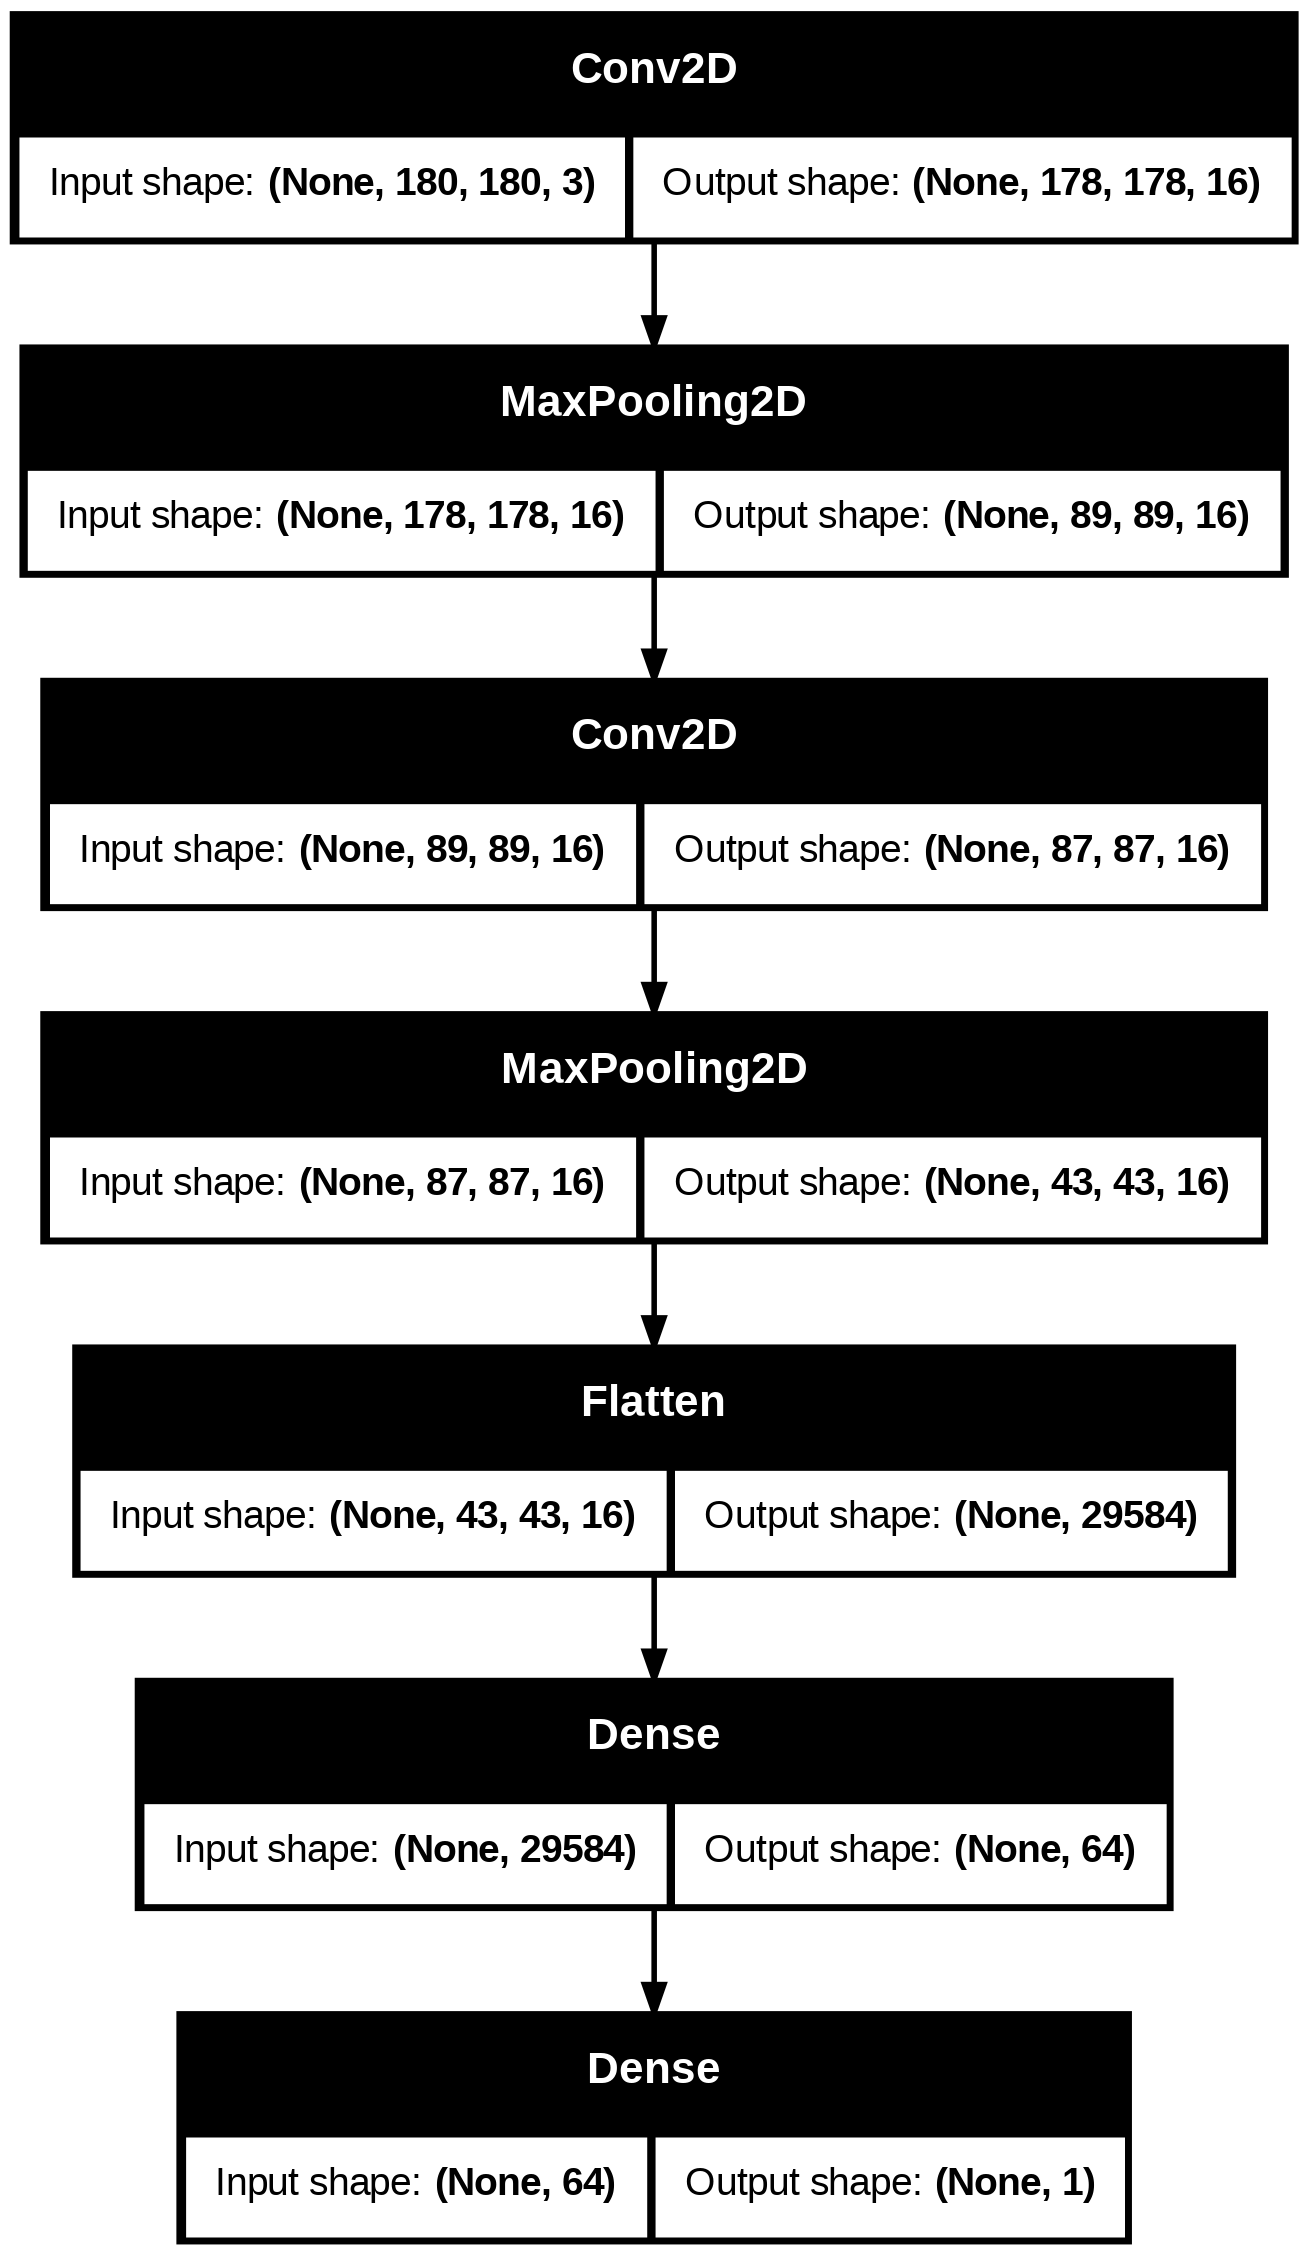

In [ ]:
model.summary()
keras.utils.plot_model(model, show_shapes=True)

##Compile and train the model

In [ ]:
epochs = 5 #for timing constraints, a common number for instance is 20-25
model.compile( # this is very important, define the optimizer, the loss and the metrics to track
    optimizer=keras.optimizers.Adam(1e-3), # for regularization
    loss="binary_crossentropy",
    metrics=["accuracy"],
)


logdir='logs' # 1.02
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir) # it allows to create the checkpoint to check the log, to save a tmp model, to see how your model is performing


# fit the data
hist = model.fit(
    train_ds, # training data
    epochs=epochs, # how long to train
    validation_data=val_ds, # we pass then the validation, we can see how the model performs in real time
    callbacks=[tensorboard_callback] # pass the callback for the checkpoint

)


# we save the output in hist in order to retrieve the information about the training of the model


Epoch 1/5
147/147 ━━━━━━━━━━━━━━━━━━━━ 100s 625ms/step - accuracy: 0.5410 - loss: 0.9051 - val_accuracy: 0.6557 - val_loss: 0.6256
Epoch 2/5
147/147 ━━━━━━━━━━━━━━━━━━━━ 85s 577ms/step - accuracy: 0.6696 - loss: 0.6153 - val_accuracy: 0.7161 - val_loss: 0.5473
Epoch 3/5
147/147 ━━━━━━━━━━━━━━━━━━━━ 87s 591ms/step - accuracy: 0.7002 - loss: 0.5720 - val_accuracy: 0.7356 - val_loss: 0.5331
Epoch 4/5
147/147 ━━━━━━━━━━━━━━━━━━━━ 146s 617ms/step - accuracy: 0.7300 - loss: 0.5364 - val_accuracy: 0.7578 - val_loss: 0.5036
Epoch 5/5
147/147 ━━━━━━━━━━━━━━━━━━━━ 88s 593ms/step - accuracy: 0.7506 - loss: 0.5102 - val_accuracy: 0.7633 - val_loss: 0.4957


NB: The loss is decreasing and the accuracy is increasing epoch by epoch

You can retrieve some information about the training

In [ ]:
hist.history

{'accuracy': [0.5843656659126282,
  0.6812793612480164,
  0.7136907577514648,
  0.7346219420433044,
  0.7550725936889648],
 'loss': [0.7272867560386658,
  0.6035527586936951,
  0.5588206648826599,
  0.5297565460205078,
  0.5014603137969971],
 'val_accuracy': [0.6557027101516724,
  0.7161469459533691,
  0.7355830669403076,
  0.7577958106994629,
  0.7633489966392517],
 'val_loss': [0.6255746483802795,
  0.5473282933235168,
  0.5331354141235352,
  0.5036084651947021,
  0.495729923248291]}

## Evaluate the model

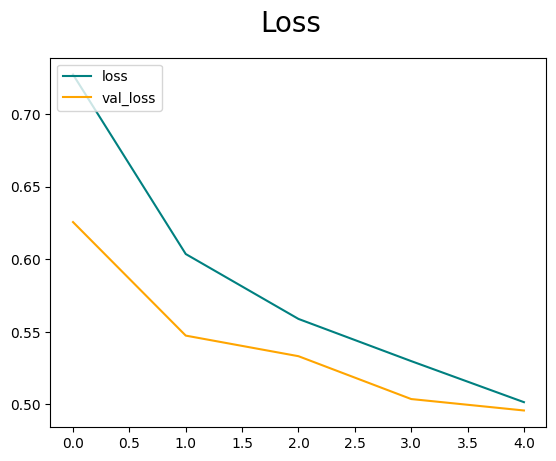

In [ ]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

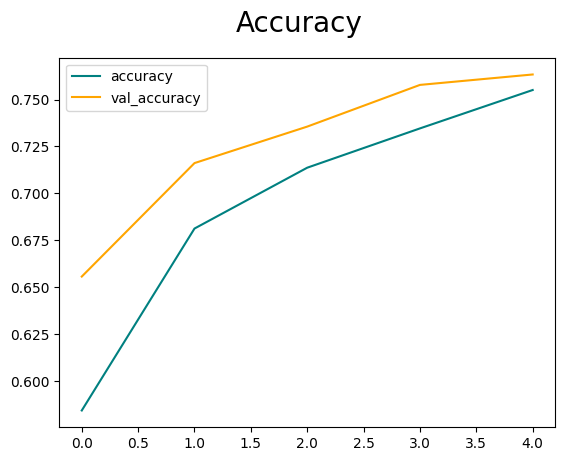

In [ ]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

## Test

Downloading...
From: https://drive.google.com/uc?id=1WTXIeWjoXwDgw2NGygAe11TRHpz4Y0cT
To: /content/img.jpg
100%|██████████| 1.25M/1.25M [00:00<00:00, 12.7MB/s]


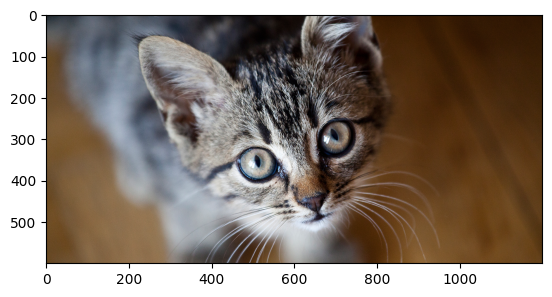

In [ ]:
!pip install gdown
import gdown
import cv2

# new images


url = "https://drive.google.com/uc?id=1WTXIeWjoXwDgw2NGygAe11TRHpz4Y0cT" #cat
#url = "https://drive.google.com/uc?id=1GlYCU3N4WqqIrIcC9V_1EtjNOYijWUsW" #dog
#url = "https://drive.google.com/uc?id=1G7pq3gDj8X0YZbzkjigImLmtO6cUFs80" #dog
#url = "https://drive.google.com/uc?id=1nTjgZg8SwyHiXr1F1cKqLtVygaZoluq3" # dog


output = "/content/img.jpg"  # Output path for the downloaded image from Google drive

gdown.download(url, output, quiet=False)
img = cv2.imread(output, cv2.IMREAD_COLOR)

rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # to adjust the color

plt.imshow(rgb_img)
plt.show()

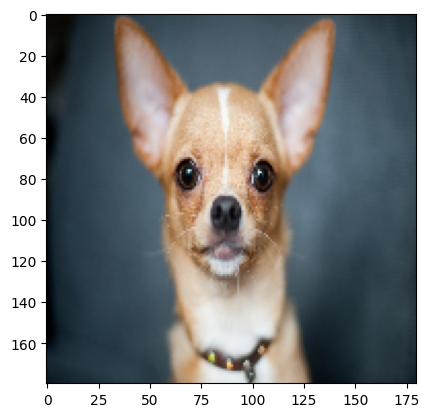

In [ ]:
resize = tf.image.resize(rgb_img, image_size)
plt.imshow(resize.numpy().astype(int))
plt.show()

In [ ]:
yhat = model.predict(np.expand_dims(resize/255, 0)) # the resize image has to be divided by 255

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


In [ ]:
yhat

array([[0.6058261]], dtype=float32)

In [ ]:
if yhat > 0.5:  # this happens in binary classification
    print(f'Predicted class is Dog')
else:
    print(f'Predicted class is Cat')

Predicted class is Dog


## Save the Model

In [ ]:
from tensorflow.keras.models import load_model # to save and load then the model

In [ ]:
model.save(os.path.join('models','imageclassifier.h5'))

In [ ]:
new_model = load_model(os.path.join('models','imageclassifier.h5'))

In [ ]:
new_model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


array([[0.9217912]], dtype=float32)